# Calculating GB energy from DF

## Objective

(i) Select data from boundaries
(ii) Organize it for all grains
(iii) Calculate the energy with wield

## Method

    * Open Dataframe
    * Select attributes of interest from boundaries
    * Create a new DF with grain information
    * Convert data to wield
    * Run wield for all grains
    * Store energy in Dataframe

In [1]:
import pandas as pd
import numpy as np
from skimage import draw,io
from skimage.segmentation import flood, flood_fill

from matplotlib import pyplot as plt


### Open Dataframe


In [2]:

folder = "../data/"
file = "1_005"
path = folder + file

#%%

sample = np.loadtxt(path+ ".txt")

'''
# Column 1-3:   right hand average orientation (phi1, PHI, phi2 in radians)
# Column 4-6:   left hand average orientation (phi1, PHI, phi2 in radians)
# Column 7:     Misorientation Angle
# Column 8-10:  Misorientation Axis in Right Hand grain
# Column 11-13: Misorientation Axis in Left Hand grain
# Column 14:    length (in microns)
# Column 15:    trace angle (in degrees)
# Column 16-19: x,y coordinates of endpoints (in microns)
# Column 20-21: IDs of right hand and left hand grains

'''


df = pd.DataFrame(  data = sample, 
                    columns = ["right_phi1","right_PHI","right_phi2",                 #1-3
                               "left_phi1","left_PHI","left_phi2",                    #4-6 
                               "ori_angle",                                           #7
                               "right_ori_x","right_ori_y","right_ori_z",              #8-10
                               "left_ori_x","left_ori_y","left_ori_z",                 #11-13  
                               "length",                                              #14
                               "trace_angle",                                         #15
                               "x_start", "y_start", "x_end", "y_end",                #16-19
                               "grain_right","grain_left"                             #20-21
                               ]                    
                 )


In [3]:
df.grain_right.drop_duplicates(keep = False)

10      1120.0
25      2455.0
35      3207.0
39      3372.0
44      3595.0
         ...  
7311    1901.0
7324    2874.0
7328    2486.0
7330    3008.0
7340     130.0
Name: grain_right, Length: 420, dtype: float64

### Select attributes of interest from boundaries

The group of information that is directly related to the grain: 
* Column 1-3:   right hand average orientation (phi1, PHI, phi2 in radians)
* Column 4-6:   left hand average orientation (phi1, PHI, phi2 in radians)
* Column 7:     Misorientation Angle
* Column 8-10:  Misorientation Axis in Right Hand grain
* Column 11-13: Misorientation Axis in Left Hand grain
* Column 20-21: IDs of right hand and left hand grains

The Columns 20-21 describe the grain of interest

The Columns 1-6 depends on grain itself, **here we are interested**

The Columns 7-13 depends on left and right grains

In [4]:
#df_left = df[['ori_angle','left_phi1','left_PHI','left_phi2','left_ori_x','left_ori_y','left_ori_z','grain_left']]
#df_right = df[['right_phi1','right_PHI','right_phi2','right_ori_x','right_ori_y','right_ori_z','grain_right']]

# left_ori is related with other grain, than is not interesting to keep in this case

df_left = df[['left_phi1','left_PHI','left_phi2','grain_left']]
df_left = df_left.rename(columns={"grain_left": "grain"})


df_right = df[['right_phi1','right_PHI','right_phi2','grain_right']]
df_right = df_right.rename(columns={"grain_right": "grain"})


In [5]:
df_left = df_left[~df_left.grain.duplicated()].sort_values('grain')
df_left = df_left.set_index('grain')


In [6]:
df_right = df_right[~df_right.grain.duplicated()].sort_values('grain')
df_right = df_right.set_index('grain')


In [7]:
#df_grains = pd.concat([df_left,df_right])
df_grains = df_left.join(df_right)
df_grains_l = df_left.join(df_right,how = "outer")
df_grains_r = df_right.join(df_left)

In [8]:
df_grains_l.isnull().sum(),df_grains_r.isnull().sum()

(left_phi1     34
 left_PHI      34
 left_phi2     34
 right_phi1    67
 right_PHI     67
 right_phi2    67
 dtype: int64,
 right_phi1     0
 right_PHI      0
 right_phi2     0
 left_phi1     34
 left_PHI      34
 left_phi2     34
 dtype: int64)

In [9]:
df_grains.sort_values('grain')

,left_phi1,left_PHI,left_phi2,right_phi1,right_PHI,right_phi2
grain,,,,,,
1.0,2.108,0.507,4.677,NaN,NaN,NaN
2.0,3.569,0.749,2.910,3.569,0.749,2.910
3.0,1.016,0.709,4.944,1.016,0.709,4.944
4.0,2.562,0.698,3.682,2.562,0.698,3.682
5.0,5.593,0.898,0.472,5.593,0.898,0.472
...,...,...,...,...,...,...
4217.0,3.249,0.193,3.117,3.249,0.193,3.117
4219.0,1.612,0.626,4.360,NaN,NaN,NaN
4220.0,1.188,0.543,4.660,1.188,0.543,4.660


In [10]:
df_grains.isnull().sum()

left_phi1      0
left_PHI       0
left_phi2      0
right_phi1    67
right_PHI     67
right_phi2    67
dtype: int64

## Fill Grains based on phi1, PHI, and phi2

In [11]:
df_grains_norm = (df_grains - df_grains.min()) / (df_grains.max() - df_grains.min())

In [12]:
grain = 123

One_grain = df[(df["grain_right"] == grain) | (df["grain_left"] == grain)]
One_grain

,right_phi1,right_PHI,right_phi2,left_phi1,left_PHI,left_phi2,ori_angle,right_ori_x,right_ori_y,right_ori_z,...,left_ori_y,left_ori_z,length,trace_angle,x_start,y_start,x_end,y_end,grain_right,grain_left
935,4.370,0.334,1.157,2.646,0.613,2.959,43.18,25.0,-6.0,-6.0,...,-6.0,-6.0,9.165,130.9,141.0,65.24,147.0,72.17,149.0,123.0
936,2.646,0.613,2.959,3.804,0.578,1.766,37.54,-12.0,11.0,5.0,...,11.0,5.0,16.042,64.1,141.0,65.24,148.0,50.81,123.0,95.0
970,2.147,0.600,4.884,2.646,0.613,2.959,16.54,25.0,-1.0,-5.0,...,-1.0,-5.0,9.165,169.1,147.0,72.17,156.0,73.90,163.0,123.0
975,2.646,0.613,2.959,5.896,0.754,0.047,20.48,7.0,5.0,-10.0,...,5.0,-10.0,18.475,150.0,148.0,50.81,164.0,60.04,123.0,110.0
976,5.896,0.754,0.047,2.646,0.613,2.959,20.48,-7.0,10.0,5.0,...,10.0,5.0,15.100,6.6,164.0,60.04,179.0,58.31,110.0,123.0
1019,3.219,0.627,3.617,2.646,0.613,2.959,31.49,-12.0,-8.0,-19.0,...,-8.0,-19.0,27.154,27.9,156.0,73.90,180.0,61.20,147.0,123.0
1149,2.646,0.613,2.959,0.185,0.331,6.106,52.47,19.0,14.0,-17.0,...,14.0,-17.0,3.055,109.1,179.0,58.31,180.0,61.20,123.0,88.0


In [13]:
grain_info = df_grains_norm.loc[grain,:]
grain_info

left_phi1     0.420927
left_PHI      0.588878
left_phi2     0.470944
right_phi1    0.420927
right_PHI     0.588878
right_phi2    0.470944
Name: 123.0, dtype: float64

In [14]:

width = int(max([max(One_grain.x_end),max(One_grain.x_start)]))+1
height = int(max([max(One_grain.y_end),max(One_grain.y_start)]))+1

width,height

(181, 74)

In [15]:
x_center = int(One_grain[['x_start','x_end']].mean().mean())
y_center = int(One_grain[['y_start','y_end']].mean().mean())

In [16]:
One_grain.y_start.iloc[1:3]

936    65.24
970    72.17
Name: y_start, dtype: float64

The method polygon_fill do not work because it uses the Even–odd rule and fill all closed paths based on directions provided as parameters. As the order or parameters meters and in our case is not ordered, this method is not helpful.


## Flood Fill method

In [17]:

np_img = np.zeros([height, width, 3])

for idx, row in One_grain.iterrows():
   # print("%d %d %d %d\n" %(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16")))
    #rr,cc = draw.polygon(One_grain.x_start, One_grain.y_start, np_img.shape)
    rr,cc,a = draw.line_aa(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16"))
    np_img[cc,rr,:3] = (1,1,1)
    
#mask = flood_fill(np_img, (50, 52,1), 255 )
mask = flood(np_img, (y_center, x_center,0))
#np_img = flood_fill(np_img, (50, 52,0), 155 )
np.shape(mask[:,:,1])



(74, 181)

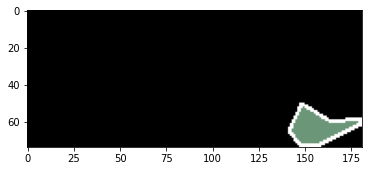

In [18]:
phi1,Phi,phi2 = grain_info[["right_phi1","right_PHI","right_phi2"]]
np_img[mask[:,:,1]] = [phi1,Phi,phi2]
phi1,Phi,phi2

plt.imshow(np_img)

Flood method works when used as a mask and apply in the original image.

Applying to all grains

In [19]:
from IPython.display import set_matplotlib_formats
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

In [20]:
width = int(max([max(df.x_end),max(df.x_start)]))+1
height = int(max([max(df.y_end),max(df.y_start)]))+1
np_img = np.zeros([height, width, 3])

for idx, row in df.iterrows():
    rr,cc,a = draw.line_aa(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16"))
    np_img[cc,rr,:3] = (1,1,1)
    
#plt.imshow(np_img)


In [21]:
import cv2

CPU times: user 1min 18s, sys: 19 s, total: 1min 37s
Wall time: 1min 37s


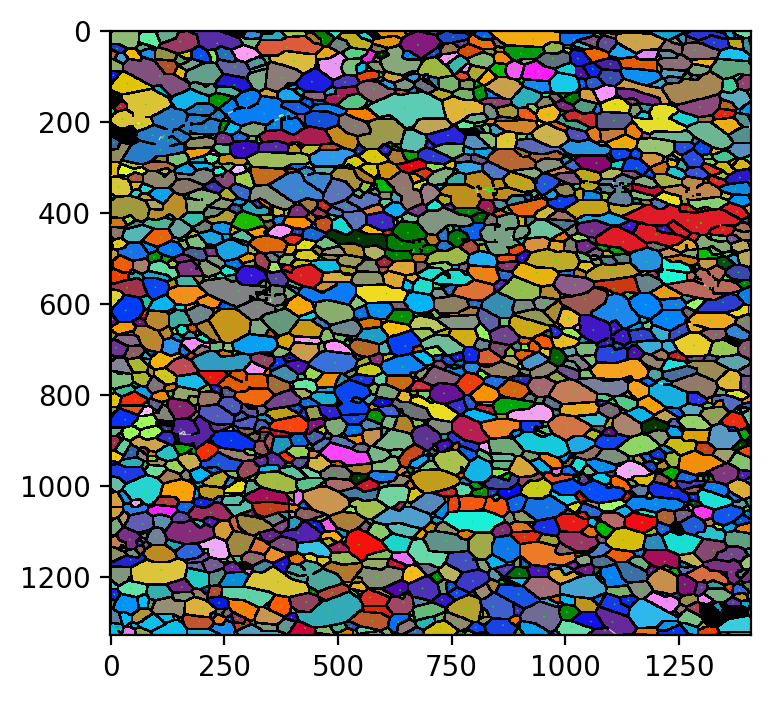

In [22]:
%%time
for grain in df_grains.index:
    df_grains_norm = (df_grains - df_grains.min()) / (df_grains.max() - df_grains.min())
    One_grain = df[(df["grain_right"] == grain) | (df["grain_left"] == grain)]
    grain_info = df_grains_norm.loc[grain,:]


    width = int(max([max(One_grain.x_end),max(One_grain.x_start)]))+1
    height = int(max([max(One_grain.y_end),max(One_grain.y_start)]))+1

    x_center = int(One_grain[['x_start','x_end']].mean().mean())
    y_center = int(One_grain[['y_start','y_end']].mean().mean())
f your favorite brand sells refurbished? Just search!

   #if(x_center > 500 and x_center < 700 and y_center >400 and y_center <600):
    mask = flood(np_img, (y_center, x_center,0))
    phi1,Phi,phi2 = grain_info[["right_phi1","right_PHI","right_phi2"]]
#    cv2.putText(np_img, text=str(int(grain)), org=(x_center,y_center),fontFace=2, fontScale=0.4, color=(255,255,255), thickness=1)
    np_img[mask[:,:,1]] = [phi1,Phi,phi2]
    r, cc = draw.disk((x_center, y_center), 2)
    np_img[cc,r] = (0,1,0)

plt.imshow(np_img)
#io.imsave("processing/"+ file +'.png',np_img)

In [23]:
io.imsave("processing/"+ file +'_partial.png',np_img)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Some grains are not in the df_grains dataframe.

In [24]:
df[df["grain_left"].isnull()]

,right_phi1,right_PHI,right_phi2,left_phi1,left_PHI,left_phi2,ori_angle,right_ori_x,right_ori_y,right_ori_z,...,left_ori_y,left_ori_z,length,trace_angle,x_start,y_start,x_end,y_end,grain_right,grain_left


In [25]:
df["grain_left"].unique()

array([1.000e+00, 3.700e+01, 6.400e+01, ..., 4.076e+03, 3.712e+03,
       1.300e+02])

In [26]:
for a in df["grain_right"].unique():
    for b in df["grain_left"].unique():
        if a == b:
          # print("right found " + str(a))
            break
        if b == df["grain_left"].unique()[-1]:
            print("right not found " + str(a))

right not found 593.0
right not found 4157.0
right not found 4198.0
right not found 598.0
right not found 1708.0
right not found 4226.0
right not found 9.0
right not found 3123.0
right not found 2615.0
right not found 2687.0
right not found 2716.0
right not found 13.0
right not found 381.0
right not found 20.0
right not found 2072.0
right not found 2284.0
right not found 2782.0
right not found 2227.0
right not found 1346.0
right not found 1603.0
right not found 1347.0
right not found 1387.0
right not found 1990.0
right not found 2061.0
right not found 2893.0
right not found 1217.0
right not found 1247.0
right not found 1519.0
right not found 3774.0
right not found 2826.0
right not found 1620.0
right not found 2545.0
right not found 3431.0
right not found 636.0


In [27]:
for a in df["grain_left"].unique():
    for b in df["grain_right"].unique():
        if a == b:
          # print("right found " + str(a))
            break
        if b == df["grain_right"].unique()[-1]:
            print("left not found " + str(a))

left not found 1.0
left not found 256.0
left not found 1321.0
left not found 1738.0
left not found 1957.0
left not found 3215.0
left not found 3383.0
left not found 3768.0
left not found 4101.0
left not found 294.0
left not found 3643.0
left not found 4153.0
left not found 4180.0
left not found 4205.0
left not found 4164.0
left not found 611.0
left not found 857.0
left not found 807.0
left not found 721.0
left not found 3401.0
left not found 209.0
left not found 1943.0
left not found 1692.0
left not found 317.0
left not found 3899.0
left not found 3744.0
left not found 2705.0
left not found 2657.0
left not found 2640.0
left not found 475.0
left not found 478.0
left not found 224.0
left not found 3001.0
left not found 4219.0
left not found 2125.0
left not found 2235.0
left not found 2255.0
left not found 75.0
left not found 699.0
left not found 1311.0
left not found 1960.0
left not found 1511.0
left not found 1952.0
left not found 1977.0
left not found 2169.0
left not found 142.0
left n

In [28]:
df

,right_phi1,right_PHI,right_phi2,left_phi1,left_PHI,left_phi2,ori_angle,right_ori_x,right_ori_y,right_ori_z,...,left_ori_y,left_ori_z,length,trace_angle,x_start,y_start,x_end,y_end,grain_right,grain_left
0,2.363,0.886,4.240,2.108,0.507,4.677,27.11,-11.0,14.0,-10.0,...,14.0,-10.0,2.000,180.0,0.0,1.15,2.0,1.15,37.0,1.0
1,5.002,0.349,1.754,2.363,0.886,4.240,28.62,13.0,21.0,-9.0,...,21.0,-9.0,1.155,30.0,0.0,15.01,1.0,14.43,64.0,37.0
2,1.506,0.572,4.119,5.002,0.349,1.754,56.44,-18.0,13.0,9.0,...,13.0,9.0,1.155,30.0,0.0,35.80,1.0,35.22,94.0,64.0
3,5.002,0.241,1.275,1.506,0.572,4.119,58.80,8.0,9.0,3.0,...,9.0,3.0,1.155,30.0,0.0,53.12,1.0,52.54,128.0,94.0
4,5.002,0.241,1.275,1.683,0.721,4.157,47.80,12.0,14.0,1.0,...,14.0,1.0,1.155,150.0,0.0,57.74,1.0,58.31,128.0,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7340,4.818,0.225,1.507,1.622,0.570,4.022,59.12,8.0,9.0,3.0,...,9.0,3.0,1.155,30.0,1406.0,53.12,1407.0,52.54,130.0,67.0
7341,1.777,0.731,4.078,4.818,0.225,1.507,47.97,1.0,-13.0,-11.0,...,-13.0,-11.0,1.155,30.0,1406.0,56.58,1407.0,56.00,137.0,130.0
7342,3.280,0.631,2.911,1.833,0.633,5.185,51.08,9.0,23.0,13.0,...,23.0,13.0,1.155,150.0,1406.0,418.00,1407.0,418.58,1856.0,1901.0
7343,6.250,0.544,0.004,3.045,0.348,3.293,39.35,-29.0,-4.0,0.0,...,-4.0,0.0,1.155,30.0,1406.0,801.36,1407.0,800.78,3206.0,3070.0


In [29]:
len(df_grains.index)

2361